Fa2
       x     y
0   18.0  67.0
1  -32.0 -31.0
2  -34.0  -3.0
3   86.0  57.0
4  -26.0  81.0
5   98.0 -31.0
6  -97.0  21.0
7  -25.0  20.0
8  -23.0  65.0
9   78.0  95.0
10  61.0  96.0
11  76.0  -3.0
12 -13.0  57.0
13  64.0  79.0
14  59.0  21.0
15 -51.0  15.0
16  64.0  96.0
17 -15.0  37.0
18  11.0  56.0
19 -15.0  52.0
20  41.0  -3.0
21  -2.0  27.0
22 -62.0  27.0
23 -61.0 -98.0
24 -46.0 -88.0
25  -6.0   2.0
26  -8.0  41.0
27 -78.0 -78.0
28  61.0 -96.0
29   1.0 -68.0
30  11.0 -85.0
31   9.0 -60.0
32 -70.0 -58.0
33 -14.0 -99.0
Edges
     source  target
0         1       2
1         1       3
2         1       4
3         1       5
4         1       6
..      ...     ...
151      34      29
152      34      30
153      34      31
154      34      32
155      34      33

[156 rows x 2 columns]
Connected
        x     y
0   -32.0 -31.0
1   -34.0  -3.0
2     NaN   NaN
3   -32.0 -31.0
4    86.0  57.0
..    ...   ...
361   9.0 -60.0
362   NaN   NaN
363 -14.0 -99.0
364 -70.0 -58.0
365   NaN   NaN

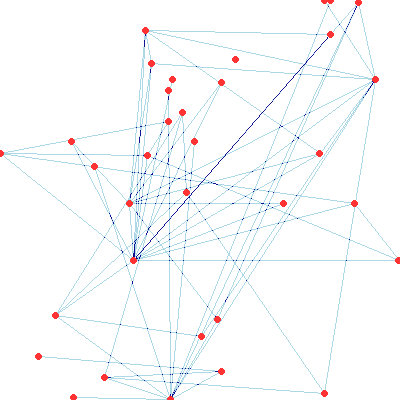

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
from datashader.utils import export_image

from itertools import chain
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import cudf
import cugraph
from random import randint

# Define the path to the test data  
datafile='../data/karate-data.csv'

# Read the data  
gdf = cudf.read_csv(datafile, names=["source", "target"], delimiter='\t')#, dtype=["int32", "int32"] )

# create a Graph using the source (src) and destination (dst) vertex pairs from the Dataframe 
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='source', destination='target')

pos_list = dict()
for i in range(G.number_of_nodes()):
    pos_list[i] = randint(-100, 100), randint(-100, 100)

k = np.fromiter(pos_list.keys(), dtype='int32')
x = np.fromiter([x for x, _ in pos_list.values()], dtype='float32')
y = np.fromiter([y for _, y in pos_list.values()], dtype='float32')

cu_pos_list = cudf.DataFrame({'x': x,
    'y' : y})


cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
                                    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


fa2 = cugraph.layout.force_atlas2(G, max_iter=0, pos_list=cu_pos_list)
print("Fa2")
print(fa2)
print("Edges")
print(gdf)

connected = connect_edges(fa2.to_pandas(), gdf.to_pandas())
print("Connected")
print(connected)

fd_d = graphplot(fa2, connected, "Force-directed") 
img = tf.Image(fd_d)
img